In [1]:
import numpy as np
import os
import threading
import operator
import pickle
import re
import pandas as pd


start_time = 1190146243
end_time = 1192994591

def dump_data(data, output_name):
    with open(output_name, 'wb') as f:
        pickle.dump(data, f)

def load_data(input_name):
    with open(input_name, 'rb') as f:
        data = pickle.load(f)
    return data

In [4]:
revisions_df = load_data("data/dump/revision_records.pkl")
access_series = load_data("data/dump/hot_words_100000.pkl")

In [8]:
'''
from ipywidgets import IntProgress
word_with_revision = set(revisions_df.index.get_level_values(0))
access_update = {}
p = IntProgress(max=100000)
p.description = 'Running'
display(p)
for word in access_series.index:
    if word not in word_with_revision:
        access_update[word] = {"access": access_series[word], "update":0}
    else:
        access_update[word] = {"access": access_series[word], "update":len(revisions_df.loc[word])}
    p.value += 1
    
access_update = pd.DataFrame(access_update).transpose()
access_update = access_update.drop(['Main_Page', 'Wiki', 'wiki'])
'''

IntProgress(value=0, description='Running', max=100000)

In [31]:
access_update = load_data("data/dump/access_update_dataframe.pkl") 
#dump_data(access_update, "data/dump/access_update_dataframe.pkl")

# Hypothesis 1: Access frequency with Update frequency 

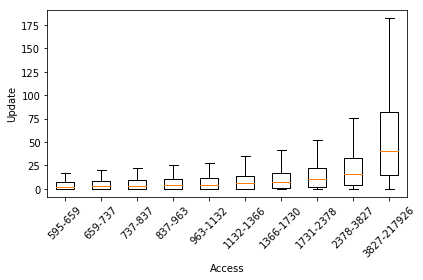

In [38]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as ss



def update_sorted_by_access(word_df):
    tuples = word_df.apply(lambda row: (row['access'], row['update']), axis=1)
    return sorted(tuples, key = lambda x: x[0]) 

access_update = load_data("data/dump/access_update_dataframe.pkl")     
sort_list = update_sorted_by_access(access_update)

fig = plt.figure()
data = []
xlabels = []
for j in range(10):
    update = list(map(lambda x: x[1], sort_list[j * 10000: (j+1) * 10000]))
    access = list(map(lambda x: x[0], sort_list[j * 10000: (j+1) * 10000]))
    data.append(update)
    xlabels.append("{}-{}".format(min(access), max(access)))
plt.boxplot(data,0, '')
plt.xticks(range(1,11), xlabels)
plt.ylabel("Update")
plt.xlabel("Access")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.tight_layout()
plt.show()
fig.savefig("plots/access-update-boxplot.png", dpi=400)


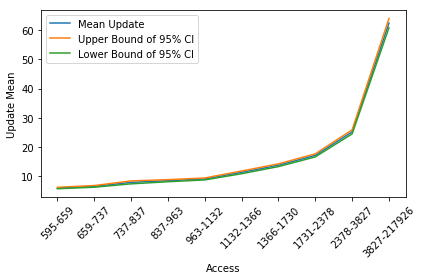

In [63]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as ss

def interval_of_mean(series, alpha):
    x = np.array(series)
    # https://books.google.com/books?id=ZBi1DAAAQBAJ&pg=PA111&lpg=PA111&dq=python+t_%7Bn-1%7D,%5Calpha/2&source=bl&ots=48wZ7PQS7K&sig=rH-nPDg3iKiaB7RKGGMvuAu31H8&hl=en&sa=X&ved=0ahUKEwj4iKrwpNTaAhUlheAKHcz5AS8Q6AEIQDAC#v=onepage&q=python%20t_%7Bn-1%7D%2C%5Calpha%2F2&f=false
    return ss.norm.interval(alpha, loc = np.mean(x), scale = ss.sem(x))

def update_sorted_by_access(word_df):
    tuples = word_df.apply(lambda row: (row['access'], row['update']), axis=1)
    return sorted(tuples, key = lambda x: x[0]) 

access_update = load_data("data/dump/access_update_dataframe.pkl")     
sort_list = update_sorted_by_access(access_update)

fig = plt.figure()
mean_data = []
upper_ci = []
lower_ci = []
xlabels = []
delta = 10000
for j in range(int(100000/delta)):
    update = list(map(lambda x: x[1], sort_list[j * delta: (j+1) * delta]))
    access = list(map(lambda x: x[0], sort_list[j * delta: (j+1) * delta]))
    interval = interval_of_mean(update, 0.95)
    lower_ci.append(interval[0])
    upper_ci.append(interval[1])
    mean_data.append(np.mean(update))
    xlabels.append("{}-{}".format(min(access), max(access)))
plt.plot(range(len(mean_data)), mean_data, label = "Mean Update")
plt.plot(range(len(mean_data)), upper_ci, label = "Upper Bound of 95% CI")
plt.plot(range(len(mean_data)), lower_ci, label = "Lower Bound of 95% CI" )
plt.xticks(range(len(mean_data)), xlabels)
plt.ylabel("Update Mean")
plt.xlabel("Access")
plt.legend()
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.tight_layout()
plt.show()
fig.savefig("plots/access-update-meanplot.png", dpi=400)

# Hypothesis 2: # vandalism with access frequency

All words are considered.

In [3]:
import numpy as np
import pandas as pd

# revision_df = load_data("data/dump/revision_records.pkl")

def check_vandalism(word, revision_df):
    revision = revision_df.loc[word]
    revision = revision.sort_values(by=['revid'])
    revision = revision.set_index('revid')
    index = revision.index
    df = pd.DataFrame(columns = ['timestamp', 'vandal','restorer','recovery time'])
    for i in range(1, len(index) - 1):
        last_record = revision.loc[index[i-1]]
        current_record = revision.loc[index[i]]
        next_record = revision.loc[index[i+1]]
        
        before_size = last_record['size']
        current_size = current_record['size']
        after_size = next_record['size']
        
        if current_size < 0.5 * after_size and after_size == before_size:
            df.loc[index[i]] = {'timestamp': current_record['timestamp'],
                                'vandal': current_record['user'], 
                                'restorer': next_record['user'],
                                'recovery time': next_record['timestamp'] - current_record['timestamp']}
   
    return df


In [ ]:
from ipywidgets import IntProgress

revision_df = load_data("data/dump/revision_records.pkl")
word_list = set(revision_df.index.get_level_values(0))
nworkers = 4
threads = [None] * nworkers
flags = [True] * nworkers

def target(index, flags, results, title):
    try:
        df = check_vandalism(title, revision_df)
    except:
        df = None
    if df is not None:
        results[title] = df
    flags[index] = True

p = IntProgress(max = len(word_list))
display(p)
results = {}
for title in word_list:
    index = 0
    while True:
        try:
            index = flags.index(True)
            flags[index] = False
            break
        except:
            continue
    t = threading.Thread(target = target, args = [index, flags, results,title])
    threads[index] = t
    t.start()
    p.value += 1
    
for thread in threads:
    if thread:
        thread.join()

vandalism_records = pd.concat(results.values(), keys = results.keys())
dump_data(vandalism_records, "data/dump/vandalism_records.pkl")

In [ ]:
from ipywidgets import IntProgress

access_series = load_data("data/dump/hot_words_100000.pkl")
vandalism_records = load_data("data/dump/vandalism_records.pkl")

word_vandalized = set(vandalism_records.index.get_level_values(0))
access_vandalism = {}
p = IntProgress(max=100000)
p.description = 'Running'
display(p)

for word in access_series.index:
    if word not in word_vandalized:
        access_vandalism[word] = {"access": access_series[word], "vandalism":0}
    else:
        access_vandalism[word] = {"access": access_series[word], "vandalism":len(vandalism_records.loc[word])}
    p.value += 1
    
access_vandalism = pd.DataFrame(access_vandalism).transpose()
access_vandalism = access_vandalism.drop(['Main_Page', 'Wiki', 'wiki'])


In [9]:
#access_vandalism = access_vandalism.drop(['Main_Page', 'Wiki', 'wiki'])
dump_data(access_vandalism, "data/dump/access_vandalism_dataframe.pkl")

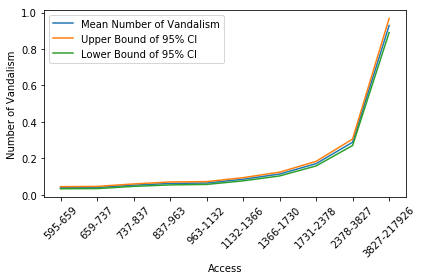

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as ss

def interval_of_mean(series, alpha):
    x = np.array(series)
    # https://books.google.com/books?id=ZBi1DAAAQBAJ&pg=PA111&lpg=PA111&dq=python+t_%7Bn-1%7D,%5Calpha/2&source=bl&ots=48wZ7PQS7K&sig=rH-nPDg3iKiaB7RKGGMvuAu31H8&hl=en&sa=X&ved=0ahUKEwj4iKrwpNTaAhUlheAKHcz5AS8Q6AEIQDAC#v=onepage&q=python%20t_%7Bn-1%7D%2C%5Calpha%2F2&f=false
    return ss.norm.interval(alpha, loc = np.mean(x), scale = ss.sem(x))

def update_sorted_by_access(word_df):
    tuples = word_df.apply(lambda row: (row['access'], row['vandalism']), axis=1)
    return sorted(tuples, key = lambda x: x[0]) 

access_vandalism = load_data("data/dump/access_vandalism_dataframe.pkl")     
sort_list = update_sorted_by_access(access_vandalism)

fig = plt.figure()
mean_data = []
upper_ci = []
lower_ci = []
xlabels = []
delta = 10000
for j in range(int(100000/delta)):
    update = list(map(lambda x: x[1], sort_list[j * delta: (j+1) * delta]))
    access = list(map(lambda x: x[0], sort_list[j * delta: (j+1) * delta]))
    interval = interval_of_mean(update, 0.95)
    lower_ci.append(interval[0])
    upper_ci.append(interval[1])
    mean_data.append(np.mean(update))
    xlabels.append("{}-{}".format(min(access), max(access)))
plt.plot(range(len(mean_data)), mean_data, label = "Mean Number of Vandalism")
plt.plot(range(len(mean_data)), upper_ci, label = "Upper Bound of 95% CI")
plt.plot(range(len(mean_data)), lower_ci, label = "Lower Bound of 95% CI" )
plt.xticks(range(len(mean_data)), xlabels)
plt.ylabel("Number of Vandalism")
plt.xlabel("Access")
plt.legend()
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.tight_layout()
plt.show()
fig.savefig("plots/access-vandalism-meanplot.png", dpi=400)

In [13]:
load_data("data/dump/vandalism_records.pkl").to_csv("data/test.csv")

# Hypothesis 3 : Deletion discovering times with frequency

I only focus on vandalized words. i.e. # vandalism >= 1

In [3]:
from ipywidgets import IntProgress

access_series = load_data("data/dump/hot_words_100000.pkl")
vandalism_records = load_data("data/dump/vandalism_records.pkl")

recovery_records = {}
p = IntProgress(max=len(vandalism_records))
p.description = 'Running'
display(p)

for i in range(len(vandalism_records)):
    record = vandalism_records.iloc[i]
    word = record.name[0]
    freq = access_series[word]
    recovery_records[i] = {"restorer": record['restorer'],
                           "recovery time": record['recovery time'],
                           "word frequency": freq}
    p.value += 1

recovery_records = pd.DataFrame(recovery_records)
dump_data(recovery_records, "data/dump/recovery_records.pkl")
    


IntProgress(value=0, description='Running', max=18490)

# Hypothesis 4: Bot VS Human